In [13]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy

# Building the PDF from particle releases

In [4]:
# for the 16 different depths, declare the indexes of the particles starting at that depth

level_indexes = {}
dz = 100
n_levels = 16

for i in range(n_levels):
    level_indexes[i*dz] = pset_1.trajectory[i::n_levels]

In [8]:
pset_1 = xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/2011/PGS_2011_023.zarr')

p1 = pset_1.isel(trajectory=level_indexes[0])
# p1.compute()

In [10]:
p1

<xarray.Dataset> Size: 48MB
Dimensions:     (trajectory: 4096, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 33kB 0 16 32 48 ... 65472 65488 65504 65520
Data variables:
    lat         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 12MB dask.array<chunksize=(4096, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DKeepInOcean
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [49]:
64*64

4096

In [59]:
2**11 + 32

2080

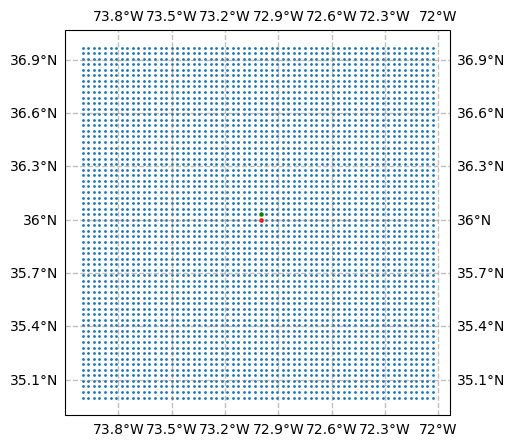

In [60]:
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
# ax.set_extent([-90, -60, 25, 50])
# add gridlines
gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.scatter(p1.lon[:,0], p1.lat[:,0], s=1)
pp = 2**5 + 2**11

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='r')

pp = 2**11 + 2**5 + 2**6

plt.scatter(p1.lon[pp,0], p1.lat[pp,0], s=5, c='g')

# for i in range(40):
    # plt.plot(pset_23.lon[i, :], pset_23.lat[i, :])